## Predicting Customer Churn in Banking Using Machine Learning

## Project Overview

This notebook presents a comprehensive machine learning project focused on predicting customer churn for a US bank. **Customer churn** refers to when customers end their relationship with a business. By accurately predicting which customers are at risk of leaving, the bank can implement targeted retention strategies to improve customer lifetime value and reduce revenue loss.

### Dataset
- **Source**: [Kaggle - Bank Customer Churn Prediction](https://www.kaggle.com/datasets/shantanudhakadd/bank-customer-churn-prediction)
- **Records**: Customer banking data with demographic, financial, and behavioral attributes
- **Target Variable**: `Exited` (binary classification: 0 = customer retained, 1 = customer churned)

## Methodology

### Data Exploration & Analysis
- **Exploratory Data Analysis (EDA)**: Univariate and bivariate analysis to understand feature distributions, relationships with churn, and data patterns
- **Visualization**: Distribution plots, correlation analysis, and categorical breakdowns to identify key churn drivers

### Data Preprocessing
- **Standardization**: StandardScaler applied to numerical features (`CreditScore`, `Age`, `Tenure`, `Balance`, `EstimatedSalary`) for optimal model performance
- **Encoding**: OneHotEncoder used to convert categorical variables into numerical representations
- **Train-Test Split**: 70-30 split

### Machine Learning Models

Four classification algorithms are trained and compared:

| Model | Algorithm Type | Key Characteristics |
|-------|---|---|
| **Random Forest** | Ensemble (Bagging) | Reduces overfitting; interpretable; robust to outliers |
| **Support Vector Machines (SVM)** | Non-parametric | Effective for binary classification; powerful in high-dimensional spaces |
| **Histogram-based Gradient Boosting** | Ensemble (Boosting) | Fast training; memory efficient; handles large datasets well |
| **XGBoost** | Ensemble (Gradient Boosting) | Industry-standard; superior predictive power; feature importance extraction |

### Evaluation Metrics

Models are evaluated using multiple metrics to provide comprehensive performance assessment:
- **Accuracy**: Overall correctness of predictions
- **Precision**: Proportion of predicted churners who actually churned (reduces false positives)
- **Recall**: Proportion of actual churners correctly identified (minimizes false negatives)
- **F1-Score**: Harmonic mean of precision and recall
- **AUC-ROC**: Area under the Receiver Operating Characteristic curve (measures discriminatory ability)

### Evaluation Visualizations
- **Precision-Recall Curves**: Trade-off between precision and recall across classification thresholds
- **ROC Curves**: True positive rate vs. false positive rate comparison
- **Confusion Matrices**: Detailed breakdown of prediction accuracy for each class
- **Feature Importance**: Identification of most influential features using XGBoost

In [285]:
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, 
                            PrecisionRecallDisplay, auc, RocCurveDisplay, classification_report, confusion_matrix, ConfusionMatrixDisplay)
from xgboost import XGBClassifier
from copy import deepcopy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [186]:
data = pd.read_csv("Churn_Modelling.csv")

In [187]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [188]:
data.drop(["RowNumber", "CustomerId", "Surname"], axis=1, inplace=True)

In [189]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [190]:
print(data['Geography'].unique())

['France' 'Spain' 'Germany']


In [191]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [192]:
data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [193]:
# checking null values
data.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [194]:
data.shape

(10000, 11)

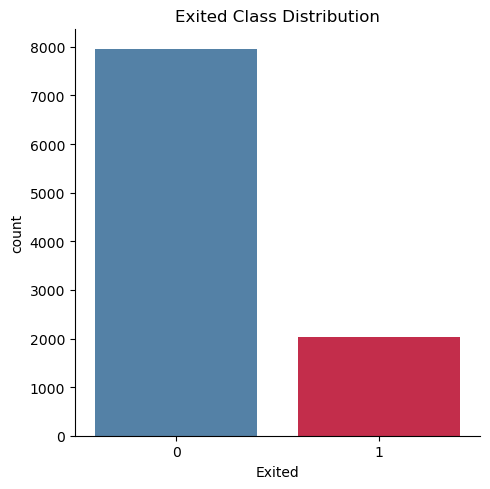

In [195]:
sns.catplot(data=data, x="Exited", kind="count", palette=["steelblue", "crimson"])
plt.title('Exited Class Distribution')
plt.tight_layout()
plt.show()

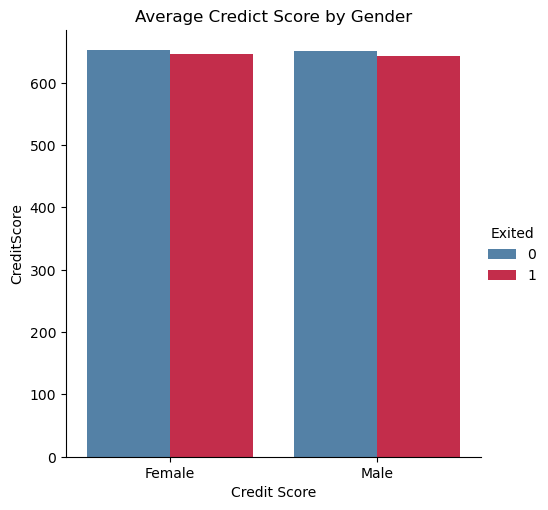

In [196]:
sns.catplot(data=data, x="Gender", y="CreditScore", kind="bar", hue="Exited", palette=["steelblue", "crimson"], errorbar=None)
plt.title("Average Credict Score by Gender")
plt.xlabel("Credit Score")
plt.show()

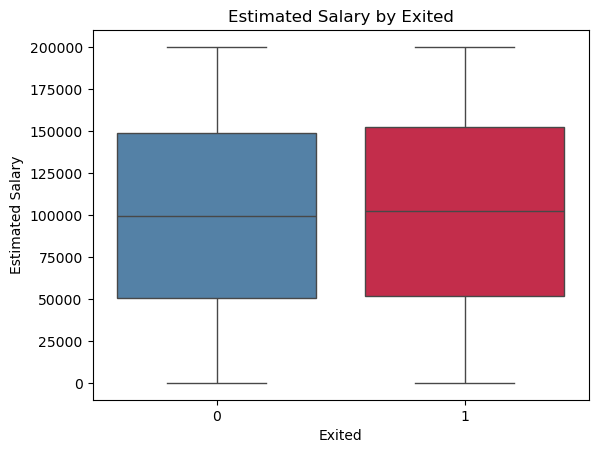

In [197]:
sns.boxplot(data=data, x="Exited", y="EstimatedSalary", palette=["steelblue", "crimson"])
plt.title("Estimated Salary by Exited")
plt.xlabel("Exited")
plt.ylabel("Estimated Salary")
plt.show()

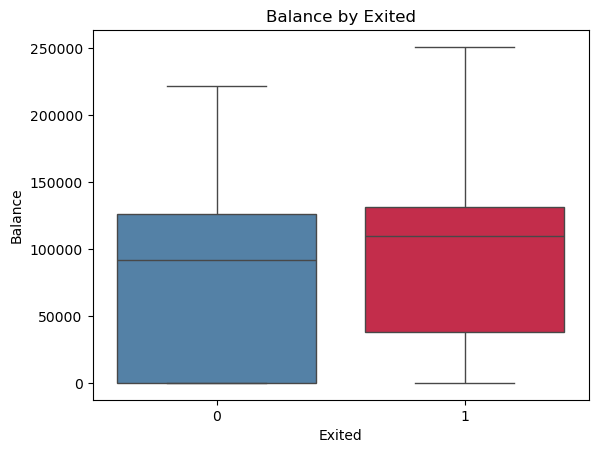

In [198]:
sns.boxplot(data=data, x="Exited", y="Balance", palette=["steelblue", "crimson"])
plt.title("Balance by Exited")
plt.xlabel("Exited")
plt.ylabel("Balance")
plt.show()

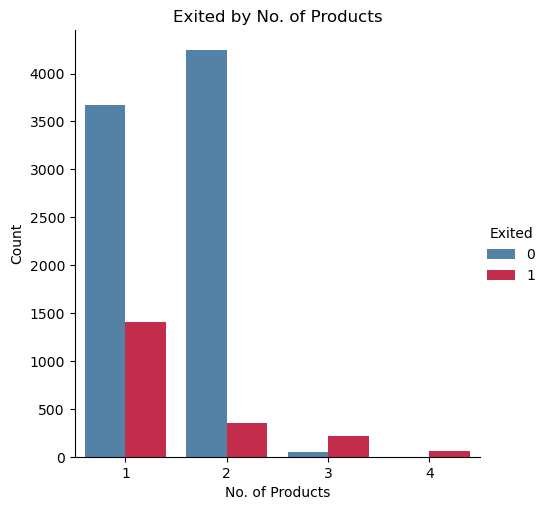

In [199]:
sns.catplot(data=data,x="NumOfProducts", hue="Exited", kind="count", palette=["steelblue", "crimson"])
plt.title("Exited by No. of Products")
plt.xlabel("No. of Products")
plt.ylabel("Count")
plt.show()

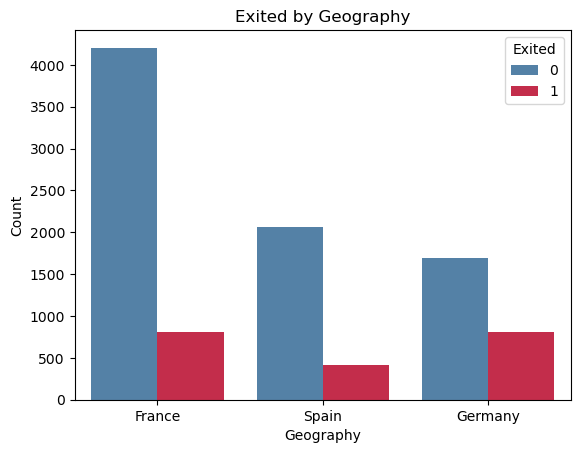

In [200]:
sns.countplot(data=data, x='Geography', hue='Exited', palette=["steelblue", "crimson"])
plt.title("Exited by Geography")
plt.xlabel("Geography")
plt.ylabel("Count")
plt.show()

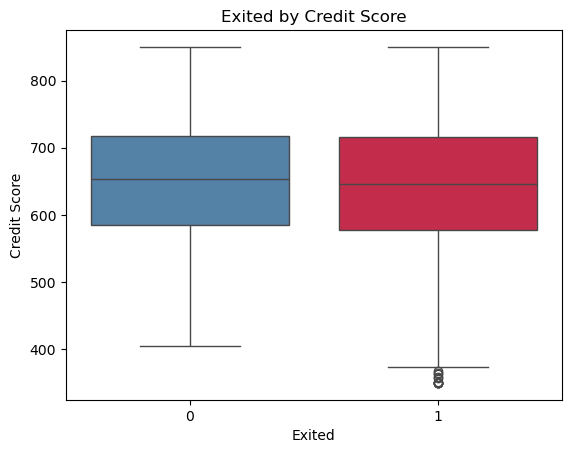

In [201]:
sns.boxplot(data=data, x="Exited", y="CreditScore", palette=["steelblue", "crimson"])
plt.title("Exited by Credit Score")
plt.xlabel("Exited")
plt.ylabel("Credit Score")
plt.show()

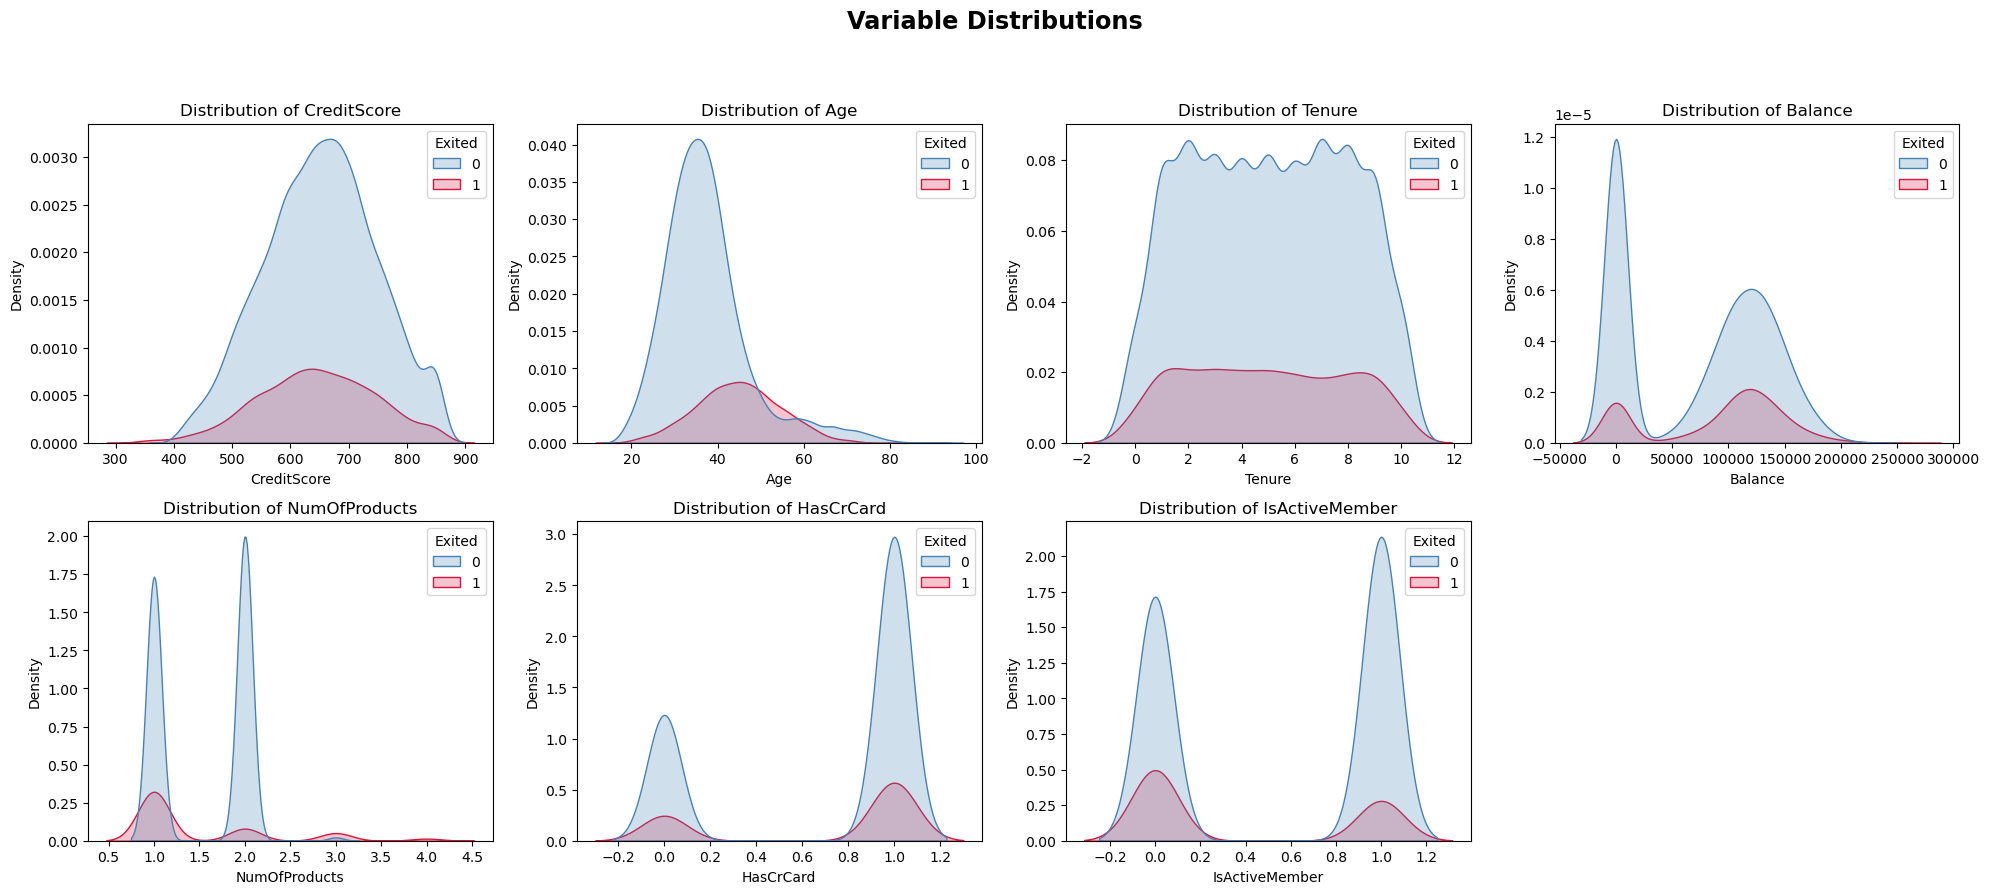

In [202]:
num_cols = [col for col in data.columns if data[col].dtype != "object"][:-2]

plt.figure(figsize=(20,20))
for i in range(len(num_cols)):
    plt.subplot(5, 4, i+1)
    sns.kdeplot(x=data[num_cols[i]], hue=data['Exited'], fill=True, palette=["steelblue", "crimson"])
    plt.title(f"Distribution of {num_cols[i]}")
    plt.tight_layout()
    plt.suptitle('Variable Distributions', fontsize='xx-large', fontweight='bold', y=1.02)
plt.show()

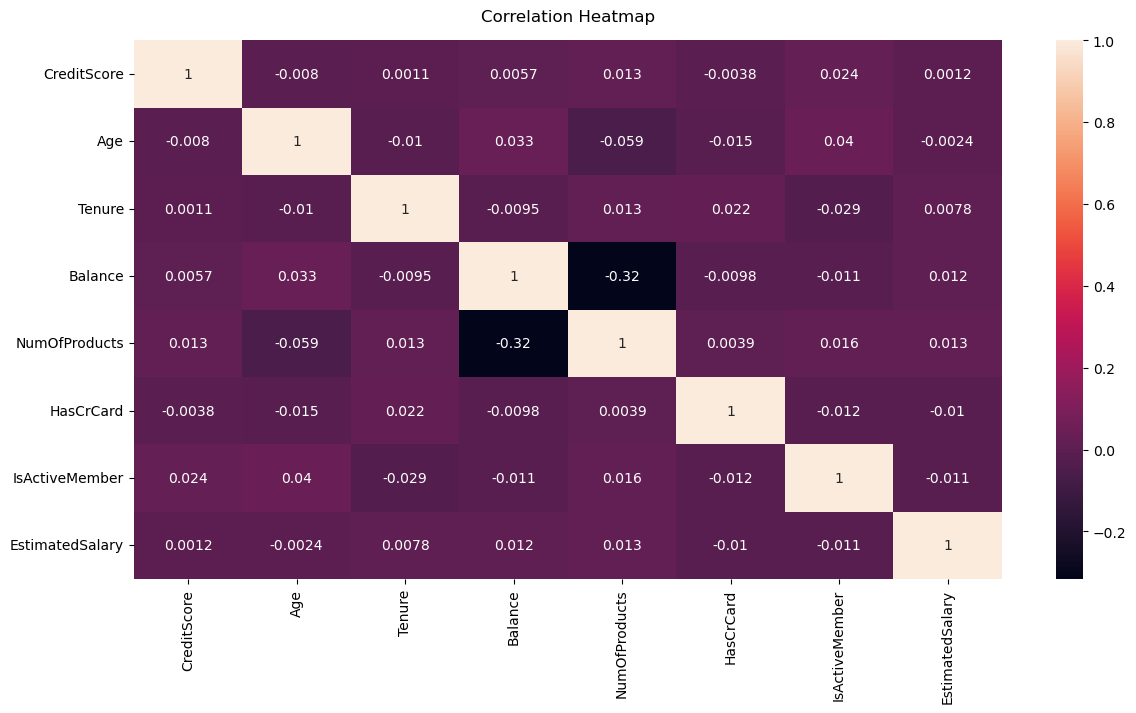

In [203]:
num_cols = [col for col in data.columns if data[col].dtype != "object"][:-1]

corr_mat = data[num_cols].corr(method='spearman')
plt.figure(figsize=(14,7))
sns.heatmap(data=corr_mat, annot=True)
plt.title("Correlation Heatmap", y=1.02)
plt.show()

### Data Preparation

In [580]:
df = deepcopy(data)

In [581]:
X = df.drop("Exited", axis=1)
y = df["Exited"]

In [582]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [583]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [584]:
cat_cols = [col for col in df.columns if df[col].dtype == "object"]
num_cols_to_scale = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

In [585]:
num_cols

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [586]:
# standardizing numeric features to improve performance and ensure equal feature contribution
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_to_scale)
    ],
    remainder='passthrough' 
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

In [587]:
new_cols = num_cols_to_scale + [col for col in X_train.columns if col not in num_cols_to_scale]

X_train_scaled = pd.DataFrame(X_train_scaled, columns=new_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=new_cols, index=X_test.index)

In [588]:
num_cols = [col for col in data.columns if data[col].dtype != "object"][:-1]

In [589]:
enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
enc_data = enc.fit_transform(X_train_scaled[cat_cols])
feature_names = enc.get_feature_names_out(cat_cols)
train_enc = pd.DataFrame(enc_data, columns=feature_names)
X_train_enc = train_enc.join(X_train_scaled[num_cols])

In [590]:
X_test_enc = enc.transform(X_test_scaled[cat_cols])
feature_names_test = enc.get_feature_names_out(cat_cols)
test_enc = pd.DataFrame(X_test_enc, columns=feature_names_test)
X_test_enc = test_enc.join(X_test_scaled[num_cols])

In [591]:
# converting object columns to float 
for col in X_train_enc:
    if X_train_enc[col].dtype == 'object':
        X_train_enc[col] = X_train_enc[col].astype(float)


for col in X_test_enc:
    if X_test_enc[col].dtype == 'object':
        X_test_enc[col] = X_test_enc[col].astype(float)

### Random Forest

In [592]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train_enc, y_train)

RandomForestClassifier()

In [593]:
y_pred_rf = rf_model.predict(X_test_enc)

accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8696666666666667


In [594]:
fpr, tpr, _ = roc_curve(y_test, y_pred_rf)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")

AUC: 0.7165273745804228


In [595]:
print(f"Training Data Score: {rf_model.score(X_train_enc, y_train)}")
print(f"Testing Data Score: {rf_model.score(X_test_enc, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8696666666666667


In [596]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2416
           1       0.77      0.47      0.58       584

    accuracy                           0.87      3000
   macro avg       0.83      0.72      0.75      3000
weighted avg       0.86      0.87      0.86      3000



### Support Vector Classification

In [597]:
sv_model = SVC()
sv_model.fit(X_train_enc, y_train)

SVC()

In [598]:
y_pred_svm = sv_model.predict(X_test_enc)

accuracy = accuracy_score(y_test, y_pred_svm)
print(f'Accuracy: {accuracy}')

Accuracy: 0.862


In [599]:
fpr, tpr, _ = roc_curve(y_test, y_pred_svm)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")

AUC: 0.6708671641114035


In [600]:
print(f"Training Data Score: {sv_model.score(X_train_enc, y_train)}")
print(f"Testing Data Score: {sv_model.score(X_test_enc, y_test)}")

Training Data Score: 0.859
Testing Data Score: 0.862


In [601]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      2416
           1       0.84      0.36      0.50       584

    accuracy                           0.86      3000
   macro avg       0.85      0.67      0.71      3000
weighted avg       0.86      0.86      0.84      3000



### Histogram-based Gradient Boosting Classification

In [602]:
hgb_model = HistGradientBoostingClassifier()
hgb_model.fit(X_train_enc, y_train)

HistGradientBoostingClassifier()

In [603]:
y_pred_hgb = hgb_model.predict(X_test_enc)

accuracy = accuracy_score(y_test, y_pred_hgb)
print(f'Accuracy:  {accuracy}')

Accuracy:  0.8736666666666667


In [604]:
fpr, tpr, _ = roc_curve(y_test, y_pred_hgb)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")

AUC: 0.7313458223714052


In [605]:
print(f"Training Data Score: {hgb_model.score(X_train_enc, y_train)}")
print(f"Testing Data Score: {hgb_model.score(X_test_enc, y_test)}")

Training Data Score: 0.9184285714285715
Testing Data Score: 0.8736666666666667


In [606]:
print(classification_report(y_test, y_pred_hgb))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2416
           1       0.77      0.50      0.61       584

    accuracy                           0.87      3000
   macro avg       0.83      0.73      0.77      3000
weighted avg       0.87      0.87      0.86      3000



### XGBoost

In [607]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train_enc, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [608]:
y_pred_xgb = xgb_model.predict(X_test_enc)

accuracy = accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy:  {accuracy}')

Accuracy:  0.8636666666666667


In [609]:
fpr, tpr, _ = roc_curve(y_test, y_pred_xgb)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")

AUC: 0.7270848453234146


In [610]:
print(f"Training Data Score: {xgb_model.score(X_train_enc, y_train)}")
print(f"Testing Data Score: {xgb_model.score(X_test_enc, y_test)}")

Training Data Score: 0.9617142857142857
Testing Data Score: 0.8636666666666667


In [611]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2416
           1       0.71      0.50      0.59       584

    accuracy                           0.86      3000
   macro avg       0.80      0.73      0.75      3000
weighted avg       0.85      0.86      0.85      3000



### Model Evaluation and Comparison

In [612]:
# evaluation function
def evaluation(actual, predicted):
    Accuracy = np.round(accuracy_score(actual, predicted), 2) 
    Precision = np.round(precision_score(actual, predicted, average='weighted'), 2) 
    Recall = np.round(recall_score(actual, predicted, average='weighted'), 2) 
    F1_Score = np.round(f1_score(actual, predicted, average='weighted'), 2)
    AUC = np.round(roc_auc_score(actual, predicted), 2) 

    result = {'Accuracy':Accuracy, 'Precision':Precision,'Recall':Recall,'F1_Score':F1_Score, 'AUC':AUC}
  
    return result

In [613]:
svm_evaluation = evaluation(y_test, y_pred_svm)
rf_evaluation = evaluation(y_test, y_pred_rf)
hgb_evaluation = evaluation(y_test, y_pred_hgb)
xgb_evaluation = evaluation(y_test, y_pred_xgb)

In [614]:
model_eval = pd.DataFrame({
    "Support Vector Machines": svm_evaluation,
    "Random Forest": rf_evaluation,
    "Histogram-based Gradient Boosting Classification": hgb_evaluation,
    "XGBoost Classification": xgb_evaluation
})
model_eval

,Support Vector Machines,Random Forest,Histogram-based Gradient Boosting Classification,XGBoost Classification
Accuracy,0.86,0.87,0.87,0.86
Precision,0.86,0.86,0.87,0.85
Recall,0.86,0.87,0.87,0.86
F1_Score,0.84,0.86,0.86,0.85
AUC,0.67,0.72,0.73,0.73


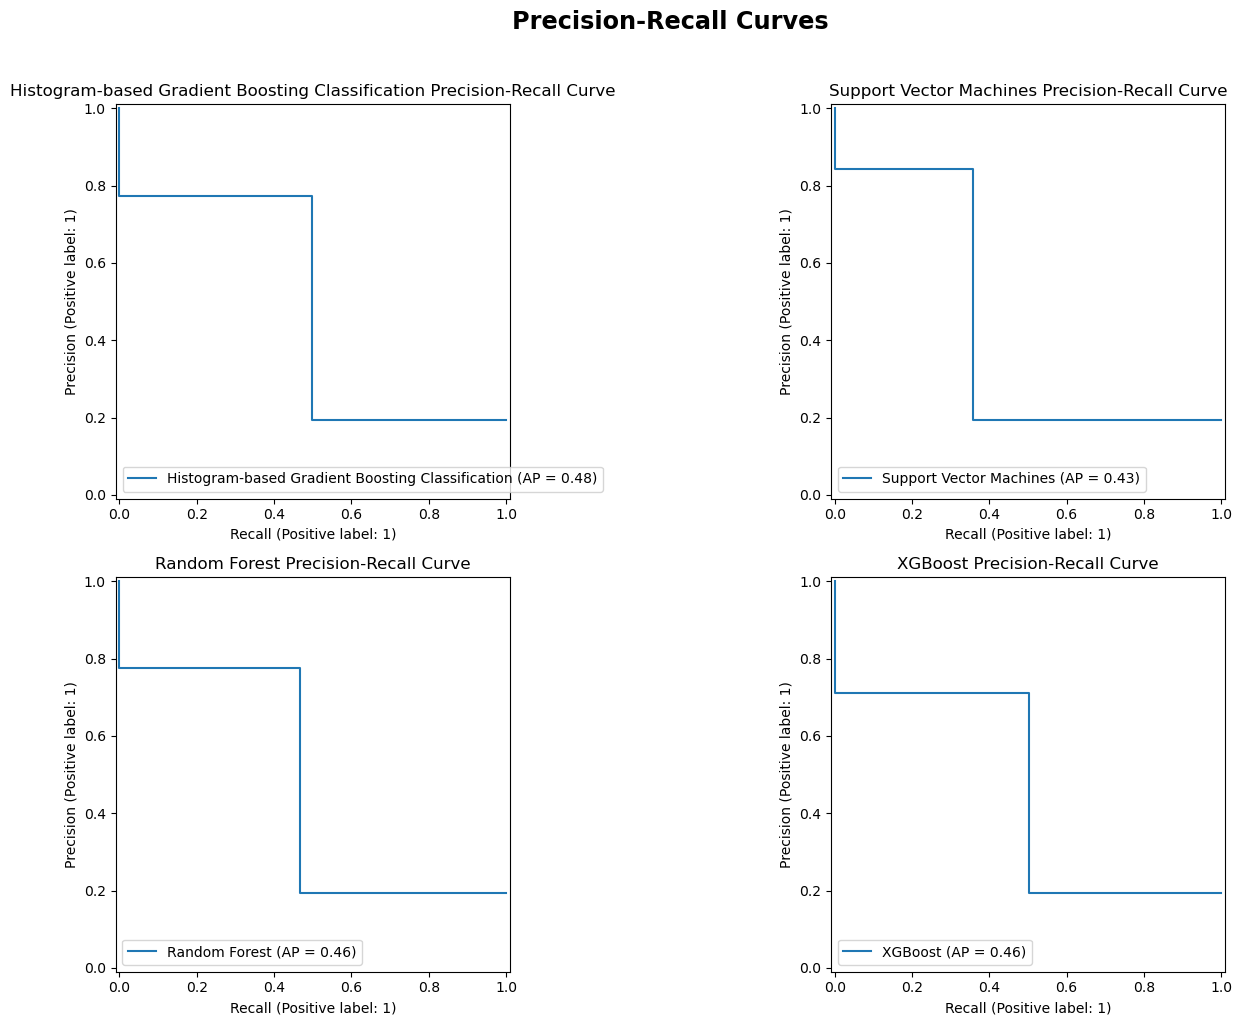

In [615]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# hgb plot 
PrecisionRecallDisplay.from_predictions(y_test, y_pred_hgb, name='Histogram-based Gradient Boosting Classification', ax=axs[0, 0])
axs[0, 0].set_title('Histogram-based Gradient Boosting Classification Precision-Recall Curve')

# svm plot
PrecisionRecallDisplay.from_predictions(y_test, y_pred_svm, name='Support Vector Machines', ax=axs[0, 1])
axs[0, 1].set_title('Support Vector Machines Precision-Recall Curve')

# rf plot
PrecisionRecallDisplay.from_predictions(y_test, y_pred_rf, name='Random Forest', ax=axs[1, 0])
axs[1, 0].set_title('Random Forest Precision-Recall Curve')

# xgboost plot
PrecisionRecallDisplay.from_predictions(y_test, y_pred_xgb, name='XGBoost', ax=axs[1, 1])
axs[1, 1].set_title('XGBoost Precision-Recall Curve')

plt.suptitle('Precision-Recall Curves', fontsize='xx-large', fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

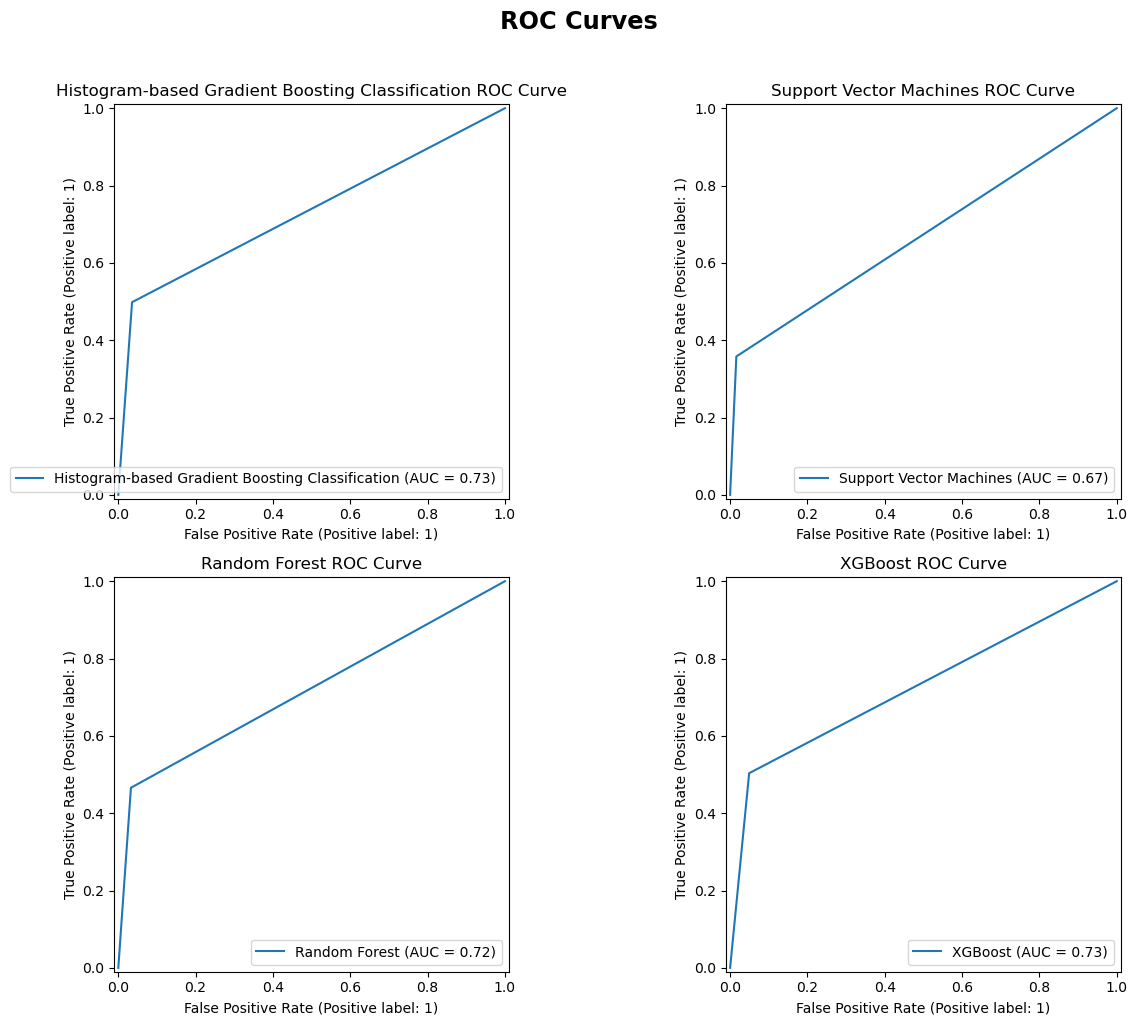

In [616]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# hgb plot
RocCurveDisplay.from_predictions(y_test, y_pred_hgb, name='Histogram-based Gradient Boosting Classification', ax=axs[0, 0])
axs[0, 0].set_title('Histogram-based Gradient Boosting Classification ROC Curve')

# svm plot
RocCurveDisplay.from_predictions(y_test, y_pred_svm, name='Support Vector Machines', ax=axs[0, 1])
axs[0, 1].set_title('Support Vector Machines ROC Curve')

# rf plot
RocCurveDisplay.from_predictions(y_test, y_pred_rf, name='Random Forest', ax=axs[1, 0])
axs[1, 0].set_title('Random Forest ROC Curve')

# xgboost plot
RocCurveDisplay.from_predictions(y_test, y_pred_xgb, name='XGBoost', ax=axs[1, 1])
axs[1, 1].set_title('XGBoost ROC Curve')

plt.suptitle('ROC Curves', fontsize='xx-large', fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

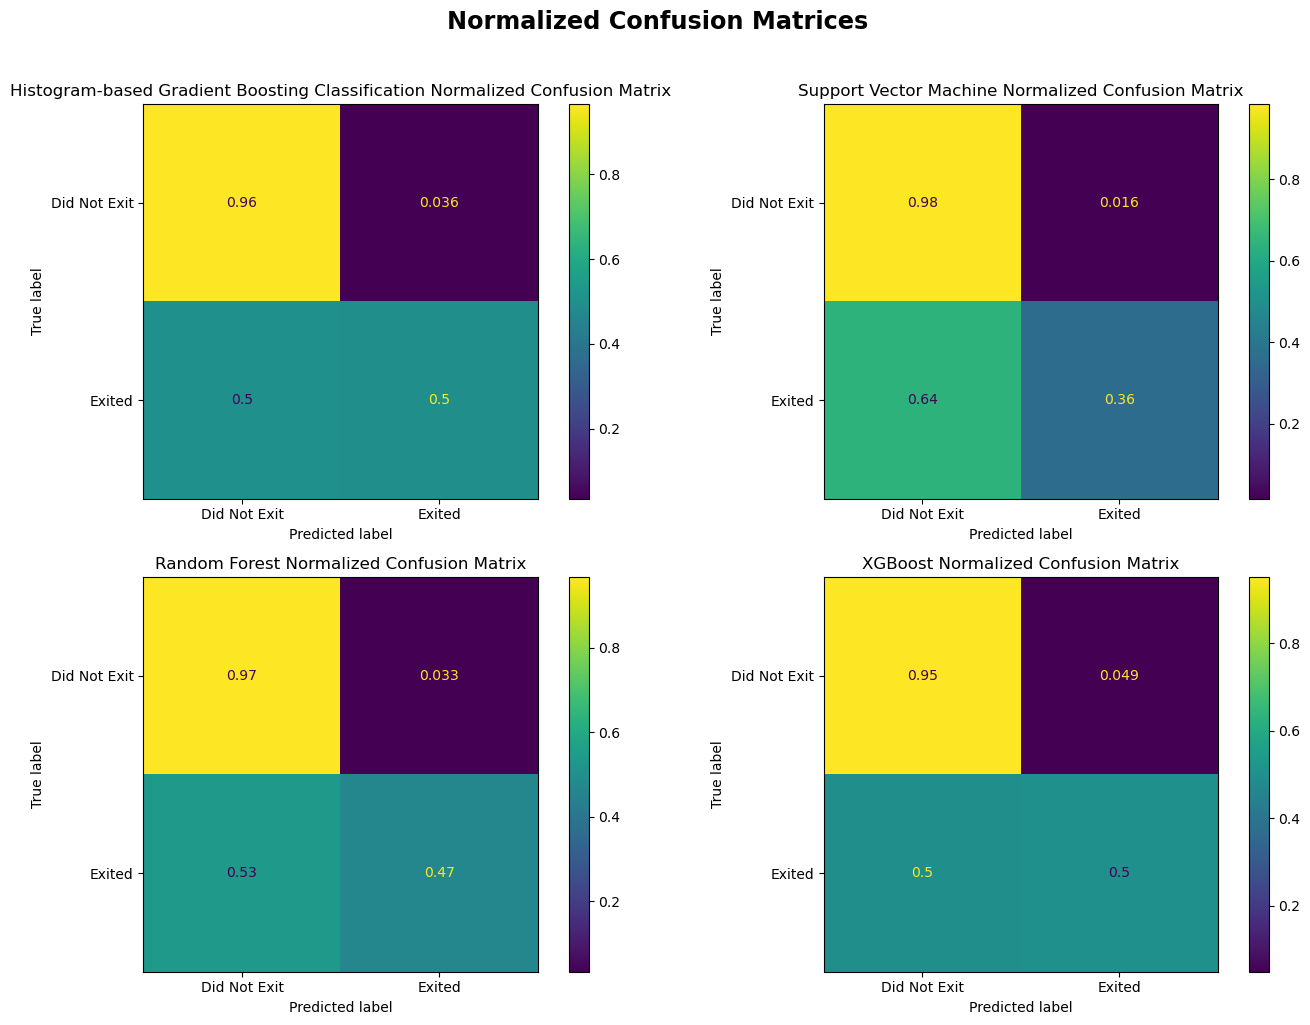

In [617]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# hgb plot
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_hgb, normalize='true', display_labels=['Did Not Exit', 'Exited'], ax=axs[0, 0])
axs[0, 0].set_title('Histogram-based Gradient Boosting Classification Normalized Confusion Matrix')

# svm plot
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, normalize='true', display_labels=['Did Not Exit', 'Exited'], ax=axs[0, 1])
axs[0, 1].set_title('Support Vector Machine Normalized Confusion Matrix')

# rf plot
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, normalize='true', display_labels=['Did Not Exit', 'Exited'], ax=axs[1, 0])
axs[1, 0].set_title('Random Forest Normalized Confusion Matrix')

# xgboost plot
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, normalize='true', display_labels=['Did Not Exit', 'Exited'], ax=axs[1, 1])
axs[1, 1].set_title('XGBoost Normalized Confusion Matrix')

plt.suptitle('Normalized Confusion Matrices', fontsize='xx-large', fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Feature Importance

In [618]:
feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train_enc.columns)
important_features = feature_importances.sort_values(ascending=False).head(10)
print('Top 10 Important Features:')
print(important_features)

Top 10 Important Features:
NumOfProducts        0.296725
IsActiveMember       0.176300
Age                  0.115155
Geography_Germany    0.096520
Balance              0.052786
Gender_Female        0.046353
Geography_Spain      0.040490
CreditScore          0.037565
Geography_France     0.037371
EstimatedSalary      0.034143
dtype: float32


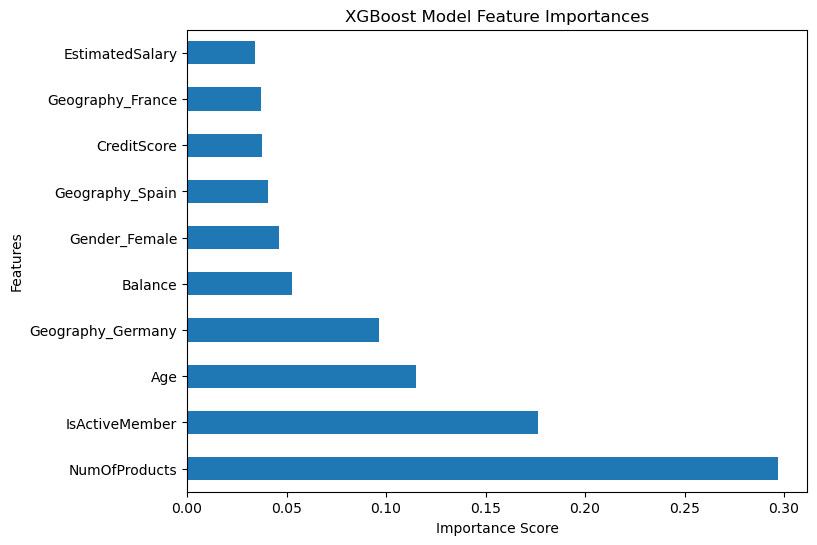

In [619]:
plt.figure(figsize=(8, 6))
important_features.plot(kind='barh')
plt.title('XGBoost Model Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()